In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
data_size = 'small_data'

In [3]:


# Load models into a dictionary
models = {
    'dummy': pd.read_csv(f'../results/test/Dummy_model/results.csv', index_col=0),
    'imbalance_volume': pd.read_csv(f'../results/test/RBF_Kernel/{data_size}/volume_imbalance/results.csv', index_col=0),
    'imbalance_value': pd.read_csv(f'../results/test/RBF_Kernel/{data_size}/value_imbalance/results.csv', index_col=0),
    'deviation_volume': pd.read_csv(f'../results/test/RBF_Kernel/{data_size}/bullshit/results.csv', index_col=0),
    'deviation_value': pd.read_csv(f'../results/test/RBF_Kernel/{data_size}/value_deviation/results.csv', index_col=0),
    #'base_case': pd.read_csv(f'../results/test/RBF_Kernel/full_data/new_base_case/results.csv', index_col=0),
 
}



for name in models:
    df = models[name]
    dt_index = pd.to_datetime(df.index, utc=True, errors='coerce').tz_convert('Europe/Copenhagen')

    # Localize only if not already tz-aware and not Dummy (we'll match it later)
    if name != 'Dummy':
        if dt_index.tz is None:
            dt_index = dt_index.tz_localize('Europe/Brussels')

    models[name].index = dt_index
    models[name]['energy_FC'] = models['dummy']['energy_FC']

models['dummy']['bids_elec'] = models['dummy']['energy_FC']

#filter dummy model to match the time range of the other models
start_date = models['imbalance_volume'].index[0]
end_date = models['imbalance_volume'].index[-1]
models['dummy'] = models['dummy'].loc[start_date:end_date]
models['dummy']


,lambda_DA_RE,lambda_IM,energy_FC,energy_RE,imbalance,DA_revenue,IM_revenue,total_revenue,bids_elec
datetime,,,,,,,,,
2019-03-22 00:00:00+01:00,39.00,33.77,3.716235,3.970588,0.254354,144.933149,8.589523,153.522672,3.716235
2019-03-22 01:00:00+01:00,35.95,33.77,5.796296,4.803922,-0.992374,208.376836,-33.512480,174.864356,5.796296
2019-03-22 02:00:00+01:00,36.69,33.77,5.432990,3.284314,-2.148676,199.336408,-72.560802,126.775606,5.432990
2019-03-22 03:00:00+01:00,36.39,41.56,0.265341,1.666667,1.401326,9.655764,58.239089,67.894853,0.265341
2019-03-22 04:00:00+01:00,38.17,42.60,0.000000,0.490196,0.490196,0.000000,20.882353,20.882353,0.000000
...,...,...,...,...,...,...,...,...,...
2019-05-29 21:00:00+02:00,47.76,29.00,0.392364,0.147059,-0.245305,18.739296,-7.113845,11.625451,0.392364
2019-05-29 22:00:00+02:00,40.77,40.77,0.930214,0.392157,-0.538057,37.924810,-21.936575,15.988235,0.930214
2019-05-29 23:00:00+02:00,34.55,31.50,1.247010,0.833333,-0.413676,43.084190,-13.030810,30.053380,1.247010


In [4]:
for model_name, df in models.items():
    print(f"Processing model: {model_name}")
    df = df.copy()

    # Required columns for all CVaR types
    required_cols = ["imbalance", "lambda_DA_RE", "lambda_IM", "energy_RE", "bids_elec", "energy_FC"]
    if not all(col in df.columns for col in required_cols):
        print(f"⚠️ Skipping {model_name}: missing columns")
        continue

    # CVaR Type 1: Imbalance Volume
    df["imbalance_volume"] = df["imbalance"].abs()

    # CVaR Type 2: Imbalance Value
    df["imbalance_value"] = (df["lambda_DA_RE"] - df["lambda_IM"]) * df["imbalance"]

    # CVaR Type 3: Forecast Deviation Volume
    df["forecast_deviation_volume"] = (df["bids_elec"] - df["energy_FC"]).abs()

    # CVaR Type 4: Forecast Deviation Value
    df["forecast_deviation_value"] = (df["lambda_DA_RE"] - df["lambda_IM"]) * (df["energy_FC"] - df["bids_elec"])

    # Save back
    models[model_name] = df



Processing model: dummy
Processing model: imbalance_volume
Processing model: imbalance_value
Processing model: deviation_volume
Processing model: deviation_value


In [5]:
models['dummy']

,lambda_DA_RE,lambda_IM,energy_FC,energy_RE,imbalance,DA_revenue,IM_revenue,total_revenue,bids_elec,imbalance_volume,imbalance_value,forecast_deviation_volume,forecast_deviation_value
datetime,,,,,,,,,,,,,
2019-03-22 00:00:00+01:00,39.00,33.77,3.716235,3.970588,0.254354,144.933149,8.589523,153.522672,3.716235,0.254354,1.330270,0.0,0.0
2019-03-22 01:00:00+01:00,35.95,33.77,5.796296,4.803922,-0.992374,208.376836,-33.512480,174.864356,5.796296,0.992374,-2.163376,0.0,0.0
2019-03-22 02:00:00+01:00,36.69,33.77,5.432990,3.284314,-2.148676,199.336408,-72.560802,126.775606,5.432990,2.148676,-6.274135,0.0,0.0
2019-03-22 03:00:00+01:00,36.39,41.56,0.265341,1.666667,1.401326,9.655764,58.239089,67.894853,0.265341,1.401326,-7.244853,0.0,-0.0
2019-03-22 04:00:00+01:00,38.17,42.60,0.000000,0.490196,0.490196,0.000000,20.882353,20.882353,0.000000,0.490196,-2.171569,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-29 21:00:00+02:00,47.76,29.00,0.392364,0.147059,-0.245305,18.739296,-7.113845,11.625451,0.392364,0.245305,-4.601922,0.0,0.0
2019-05-29 22:00:00+02:00,40.77,40.77,0.930214,0.392157,-0.538057,37.924810,-21.936575,15.988235,0.930214,0.538057,-0.000000,0.0,0.0
2019-05-29 23:00:00+02:00,34.55,31.50,1.247010,0.833333,-0.413676,43.084190,-13.030810,30.053380,1.247010,0.413676,-1.261713,0.0,0.0


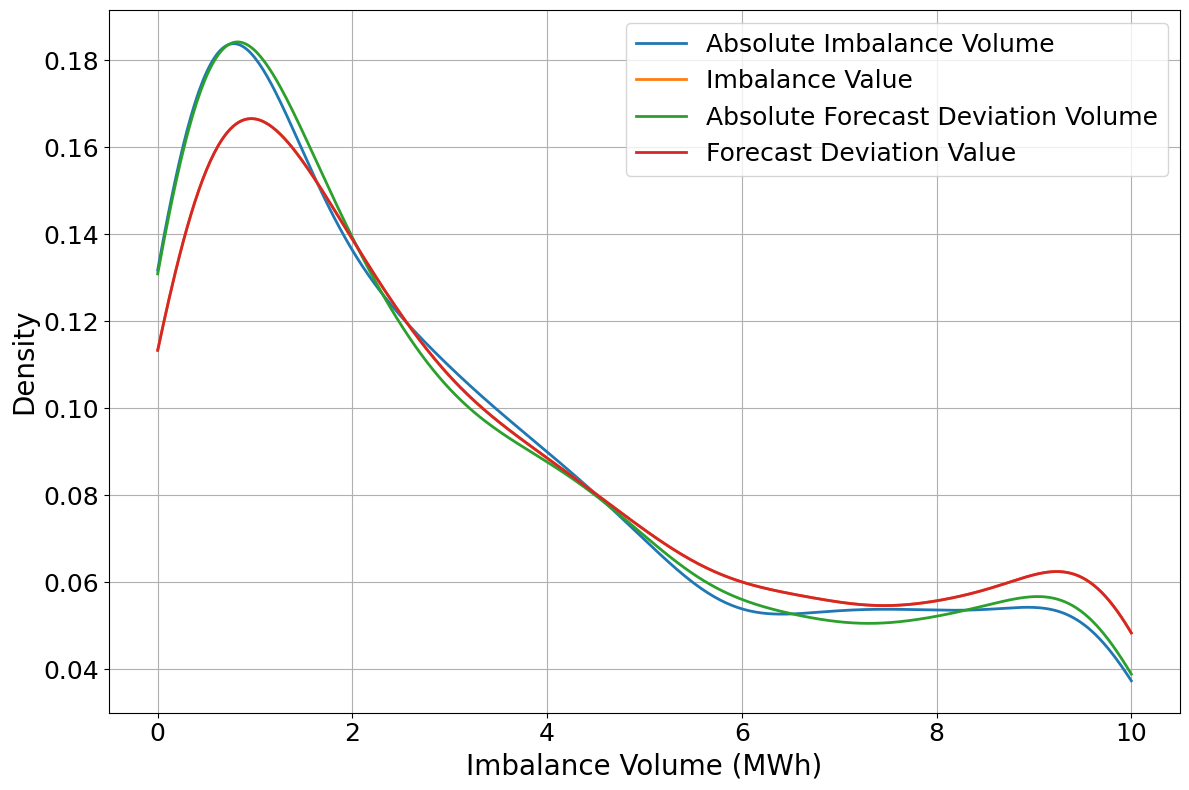

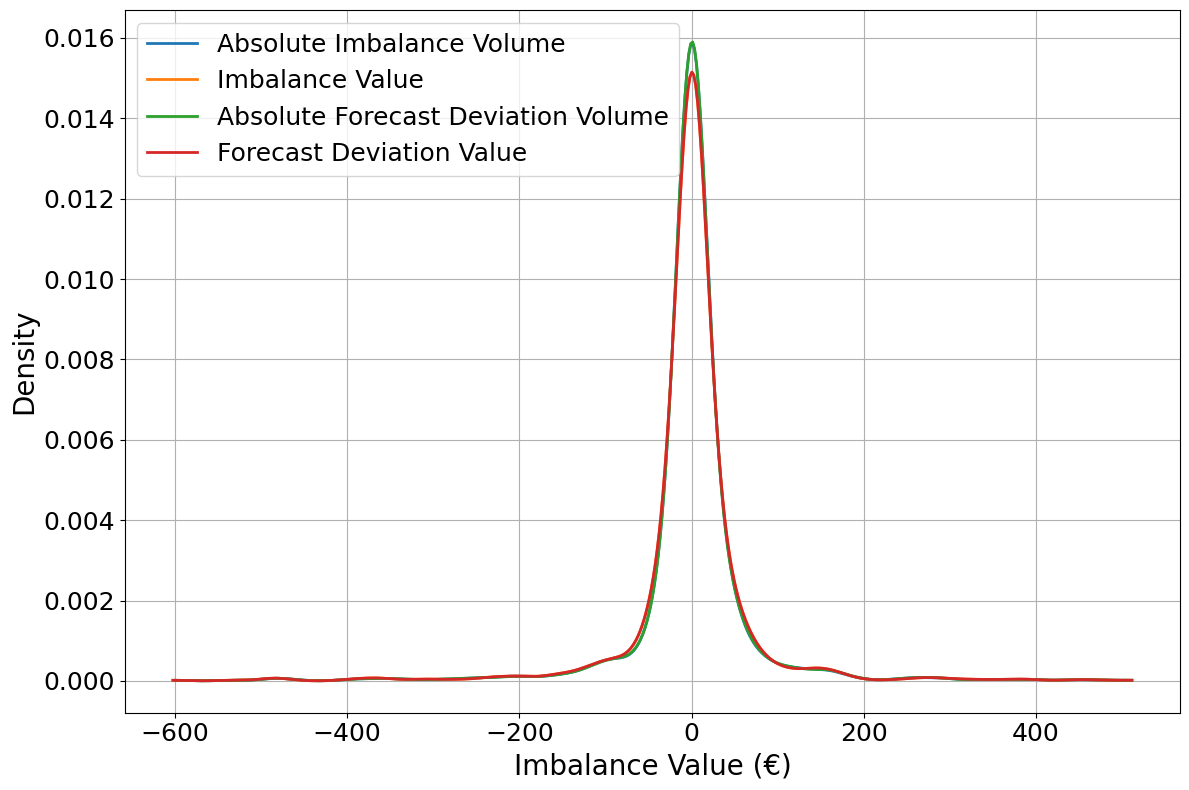

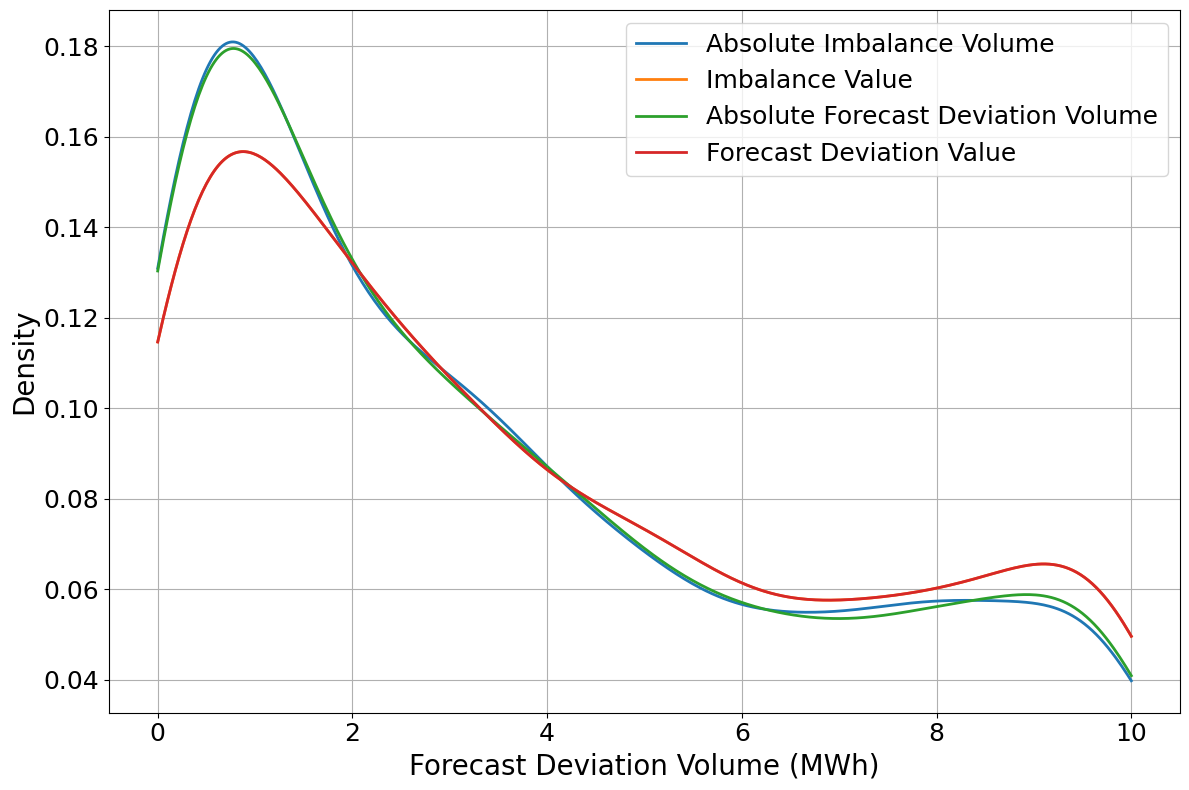

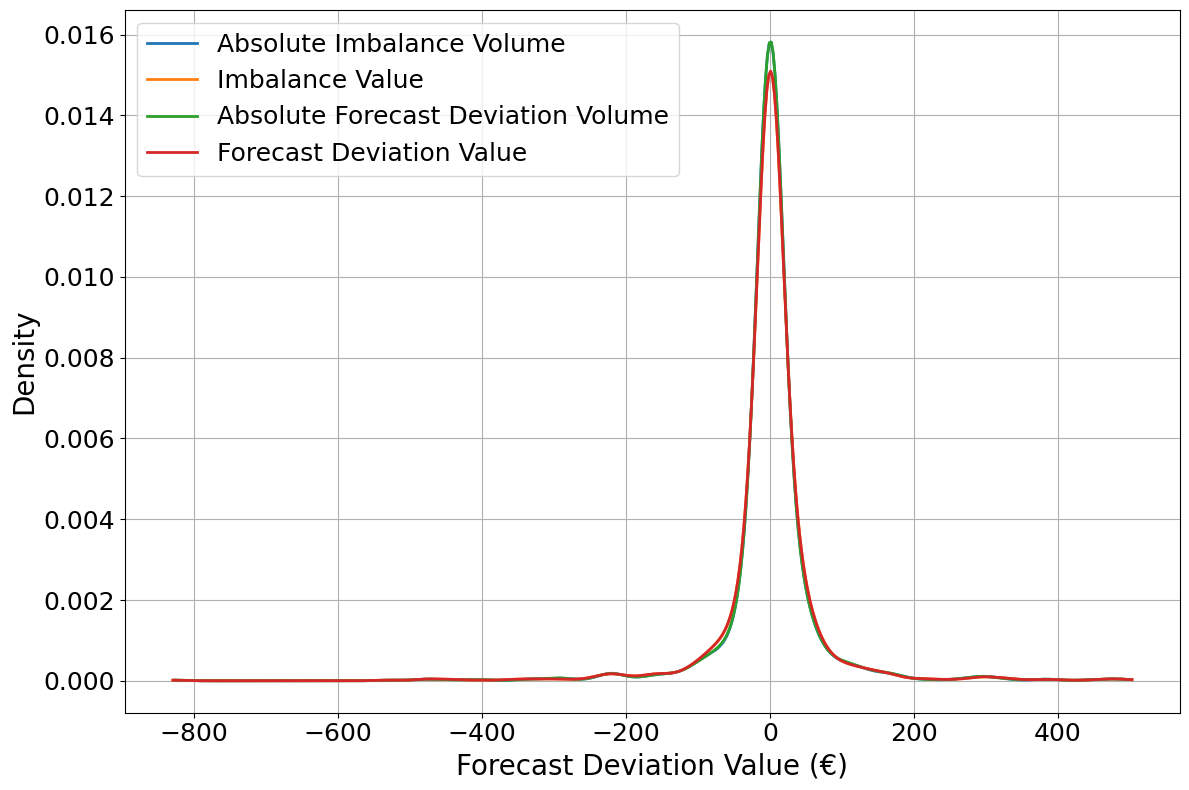

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# List of CVaR columns to plot
cvar_columns = [
    "imbalance_volume",
    "imbalance_value",
    "forecast_deviation_volume",
    "forecast_deviation_value"
]

# Human-readable labels
cvar_labels = {
    "imbalance_volume": "Imbalance Volume (MWh)",
    "imbalance_value": "Imbalance Value (€)",
    "forecast_deviation_volume": "Forecast Deviation Volume (MWh)",
    "forecast_deviation_value": "Forecast Deviation Value (€)"
}

legend_labels = {
    "dummy": "Dummy Model",
    "imbalance_volume": "Absolute Imbalance Volume",
    "imbalance_value": "Imbalance Value",
    "deviation_volume": "Absolute Forecast Deviation Volume",
    "deviation_value": "Forecast Deviation Value"
}

for cvar_col in cvar_columns:
    fig = plt.figure(figsize=(12, 8))

    for model_name, df in models.items():
        if model_name == 'dummy':
            continue
        if cvar_col not in df.columns:
            continue

        data = df[cvar_col].dropna()

        # ✅ Skip if not enough unique points
        if len(np.unique(data)) < 2:
            print(f"⚠️ Skipping {model_name} for {cvar_col}: not enough variation.")
            continue

        try:
            kde = gaussian_kde(data)
            x_vals = np.linspace(data.min(), data.max(), 500)
            y_vals = kde(x_vals)
            plt.plot(x_vals, y_vals, label=f"{legend_labels[model_name]}", linewidth=2)
        except Exception as e:
            print(f"⚠️ KDE failed for {model_name} - {cvar_col}: {e}")

    plt.xlabel(cvar_labels[cvar_col], fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', labelsize=18)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
# List of CVaR columns
cvar_columns = [
    "imbalance_volume",
    "imbalance_value",
    "forecast_deviation_volume",
    "forecast_deviation_value"
]

# Set alpha
alpha = 0.9

# Container for results
cvar_table = pd.DataFrame(columns=cvar_columns)

# Compute CVaR for each model and each column
for model_name, df in models.items():
    cvar_row = {}

    for col in cvar_columns:
        if col not in df.columns:
            cvar_row[col] = None
            continue

        # Right-tail CVaR: average of values >= 90% quantile
        threshold = df[col].quantile(alpha)
        cvar_value = df.loc[df[col] >= threshold, col].mean()
        cvar_row[col] = cvar_value

    # Add to table
    cvar_table.loc[model_name] = cvar_row

# Display nicely
cvar_table = cvar_table.round(2)
print("\nCVaR Table (α = 90%, right-tail):")
display(cvar_table)



CVaR Table (α = 90%, right-tail):


,imbalance_volume,imbalance_value,forecast_deviation_volume,forecast_deviation_value
dummy,3.36,32.00,0.00,0.00
imbalance_volume,9.35,113.52,9.42,116.60
imbalance_value,9.59,115.84,9.62,118.13
deviation_volume,9.39,114.72,9.44,117.58
deviation_value,9.59,115.84,9.62,118.13


In [8]:
# Container for full mean values
mean_table = pd.DataFrame(columns=cvar_columns)

# Compute mean for each model and column
for model_name, df in models.items():
    mean_row = {}

    for col in cvar_columns:
        if col not in df.columns:
            mean_row[col] = None
        else:
            mean_row[col] = df[col].mean()

    mean_table.loc[model_name] = mean_row

# Display rounded mean table
mean_table = mean_table.round(2)
print("\nMean Table (Full Average of Each CVaR Column):")
display(mean_table)



Mean Table (Full Average of Each CVaR Column):


,imbalance_volume,imbalance_value,forecast_deviation_volume,forecast_deviation_value
dummy,0.98,-0.52,0.00,0.00
imbalance_volume,3.53,0.59,3.61,1.11
imbalance_value,3.81,0.04,3.90,0.56
deviation_volume,3.54,0.71,3.62,1.23
deviation_value,3.81,0.04,3.90,0.56


In [9]:
# Container for cumulative profit
profit_table = pd.DataFrame(columns=["Cumulative Profit", "Percentage of Dummy"])

# Compute total profit per model
dummy_profit = models["dummy"]["total_revenue"].sum()

for model_name, df in models.items():
    total_profit = df["total_revenue"].sum()
    relative = 100 * total_profit / dummy_profit if dummy_profit != 0 else None

    profit_table.loc[model_name] = {
        "Cumulative Profit": total_profit,
        "Percentage of Dummy": relative
    }

# Round for readability
profit_table = profit_table.round(2)

print("\nCumulative Profit Table:")
display(profit_table)



Cumulative Profit Table:


,Cumulative Profit,Percentage of Dummy
dummy,256790.25,100.00
imbalance_volume,254950.03,99.28
imbalance_value,255864.11,99.64
deviation_volume,254750.94,99.21
deviation_value,255864.11,99.64
